In [87]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import pyarrow.parquet as pq
from utilities import load_risks_dicts
from sklearn.cluster import DBSCAN
from collections import Counter

In [68]:
def get_tsne(x, seed=0):
    # Create a t-SNE instance 
    tsne = TSNE(n_components=2, random_state=seed)
    # Fit and apply t-SNE to the dataset
    X_tsne = tsne.fit_transform(x)
    return X_tsne


def get_symbols_for(results, labels, label):
    symbols = np.array([r["symbol_name"] for r in results if type(r["embedding"]) == np.ndarray])
    indices = np.where(labels == label)
    return symbols[indices]

def get_risk_embeddings_per_symbol(symbol_to_plain_risk):
    results = []
    skipped = []
    for risk_record in tqdm(symbol_to_plain_risk):
        try:
            record = {}
            record["symbol_name"] = risk_record["symbol_name"]
            risks = risk_record["risks"]
            risk_vectors = np.array([risk_to_embed[risk] for risk in risk_record["risks"]])
            # Using addition to combine embeddings into a document
            # https://web.stanford.edu/~jurafsky/slp3/ read on embeddings
            record["embedding"] = np.sum(risk_vectors, axis=0)
            results.append(record)
        except Exception as e:
            skipped.append(risk_record['symbol_name'])
    print(f"Skipped: {len(skipped)}")
    print(f"Skipped examples: {skipped[:5]}")
    return results


def plot_labels(graph_labels, X):
    unique_labels = np.unique(graph_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure(figsize=(10, 10))
    # Plot each unique label with its corresponding color
    for (label, color) in zip(unique_labels, colors):
        x = X[graph_labels == label, 0]
        y = X[graph_labels == label, 1]
        plt.scatter(x, y, color=color, s=1, label=f'Cluster {label}')

    plt.legend(loc='best')  # Display legend
    plt.show()


In [14]:
risk_to_embedding_df = pq.read_table("./data/staging/risk_to_embedding_openai.parquet").to_pandas()

In [15]:
# Verifying that all our embeddings have correct format
risk_to_embedding_df.embedding.map(len).unique()

array([3072])

## Reduce number of dimensions
- We are dealing with 3072 dimensions per row. Let's reduce it and plot to see if we can see any structure.

In [16]:
# Making sure that we are dealing with correct data types
embeddings = np.array([row for row in risk_to_embedding_df.embedding.values])

In [17]:
# Let's try decomposing variation along two axis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)

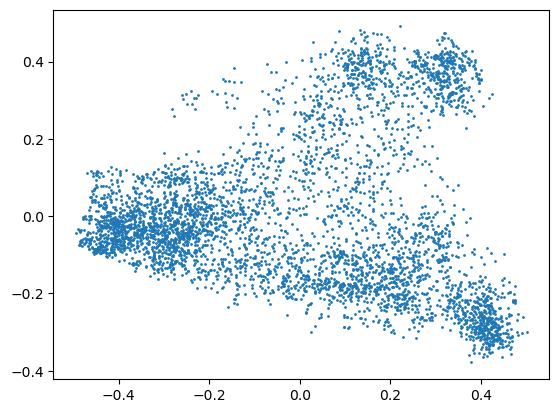

In [18]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)

- We appear to have around three clusters of data. Meaning that some risks are more closely grouped than the others.

## Compute embedding per symbol


In [19]:
records = risk_to_embedding_df.to_dict(orient="records")

In [20]:
# Create a map from risk to embedding for easier retrieval
risk_to_embed = {record["risk_name"]: record["embedding"] for record in records}

In [72]:
json_dicts = load_risks_dicts()

 35%|███▍      | 905/2600 [00:00<00:00, 4713.73it/s]

NWH.UN.TO
XMY.TO
QCD.TO


 81%|████████  | 2104/2600 [00:00<00:00, 5574.10it/s]

RIFI.TO
BN.PF.F.TO
BOS.TO
DRM.TO
PRU.TO
ECN.DB.TO


100%|██████████| 2600/2600 [00:00<00:00, 5515.15it/s]


In [69]:
results = get_risk_embeddings_per_symbol(json_dicts)

100%|██████████| 2591/2591 [00:00<00:00, 3942.36it/s]


Skipped: 10
Skipped examples: ['AYZ.C.TO', 'AYZT.TO', 'EEMFB.TO', 'EYZ.B.TO', 'EYZ.D.TO']


## Explore embeddings
- Apply t-SNE to check if we observe any structure
- Do DBSCAN to observe if we can extract relevant clusters

In [73]:
X = np.array([r["embedding"] for r in results if type(r["embedding"]) == np.ndarray])

In [74]:
X_tsne = get_tsne(X)

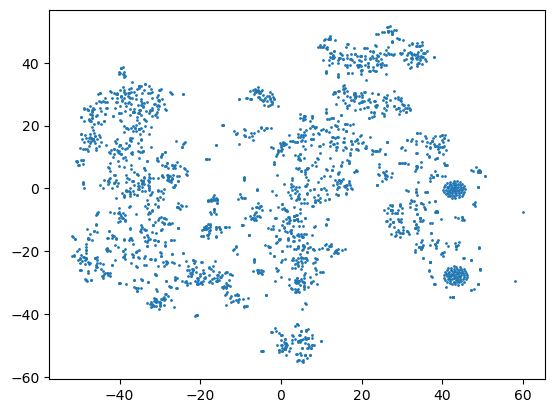

In [75]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=1)

- We can see that there's couple of clear groupings of stocks that have similar risk embeddings.

Let's run K-means with around 20 clusters to see if we can label some of those. It would allow us to filter our dataset and look at them more.

In [63]:
kmeans = KMeans(n_clusters=20, random_state=1)
kmeans.fit(X_tsne)
kmeans_labels = kmeans.predict(X_tsne)

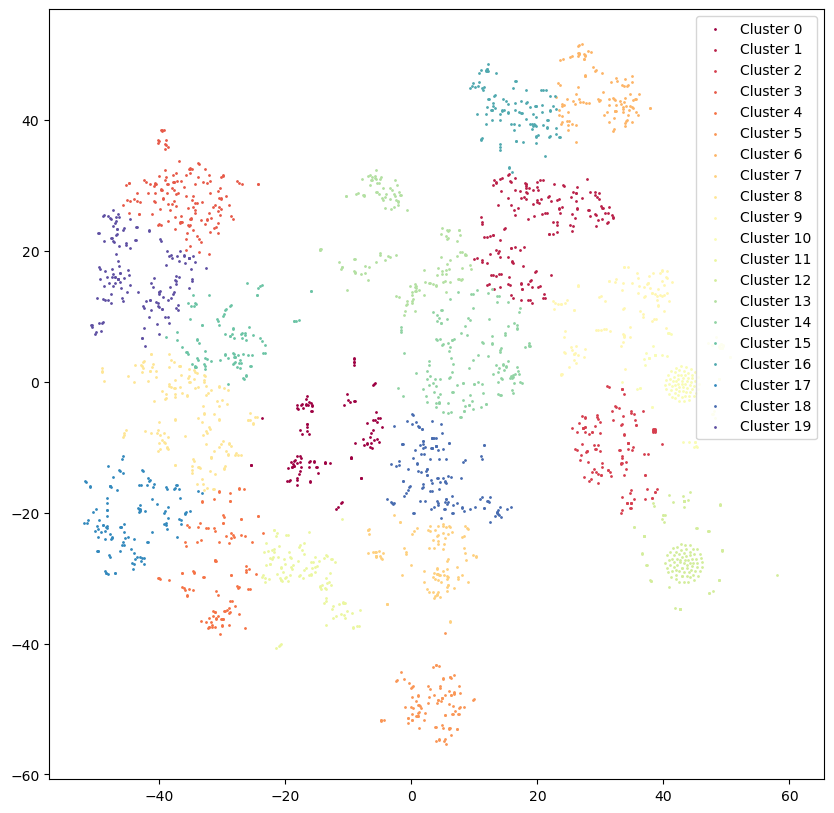

In [66]:
plot_labels(kmeans_labels, X_tsne)

In [77]:
get_symbols_for(results, kmeans_labels, 12)

array(['RUDB.U.TO', 'CDEF.TO', 'PYF.U.TO', 'DGS.TO', 'CMAR.TO', 'IGCF.TO',
       'BNC.TO', 'FCGB.TO', 'MPAY.U.TO', 'FEBB.F.TO', 'TDB.TO', 'EARN.TO',
       'MPAY.TO', 'RUDH.TO', 'SBC.PR.A.TO', 'CGRE.TO', 'PINC.TO',
       'BMAX.TO', 'RQP.TO', 'IGAF.TO', 'DF.PR.A.TO', 'FCSB.TO', 'XFLB.TO',
       'FFH.PR.H.TO', 'CXF.TO', 'UCSH.U.TO', 'SYLD.TO', 'ZWB.U.TO',
       'XBB.TO', 'BXF.TO', 'CGIN.U.TO', 'VCIP.TO', 'BOND.TO', 'RQQ.TO',
       'BOND.B.TO', 'ISCB.TO', 'DXP.TO', 'DANC.TO', 'BSKT.TO', 'XSC.TO',
       'FC.DB.J.TO', 'FTU.PR.B.TO', 'FHIS.TO', 'CCOR.TO', 'CAFR.TO',
       'TQGD.TO', 'EIT.PR.B.TO', 'NPS.TO', 'PABF.TO', 'ESGH.F.TO',
       'CINC.U.TO', 'PGI.UN.TO', 'ZFS.L.TO', 'ZRR.TO', 'EIT.UN.TO',
       'DQD.TO', 'CEW.TO', 'NSCC.TO', 'PYF.B.TO', 'PBD.TO', 'ZPAY.U.TO',
       'SBC.TO', 'TUHY.TO', 'FSB.TO', 'YCM.TO', 'TIPS.TO', 'PVS.PR.J.TO',
       'PFMS.TO', 'ZCPB.TO', 'NALT.TO', 'ZJK.TO', 'PTI.UN.TO', 'PMIF.TO',
       'HAF.TO', 'QUB.TO', 'CACB.TO', 'CMNY.TO', 'ZST.TO', 'IWEB.TO',
 

- These are the stocks that are related to financial sector.
- We see some bond ets and treasury etfs here.

## Let's use DBScan

In [81]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

In [84]:
len(set(dbscan_labels))

8

In [86]:
Counter(dbscan_labels)

Counter({-1: 2391, 0: 72, 2: 64, 6: 11, 4: 9, 1: 5, 3: 5, 5: 5})

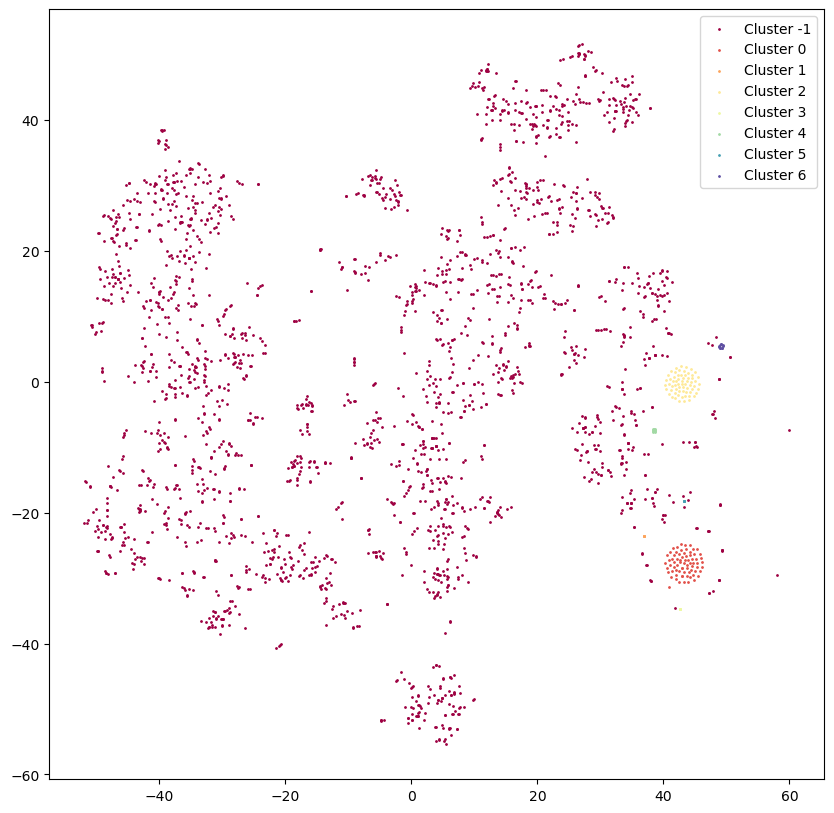

In [94]:
plot_labels(dbscan_labels, X_tsne)

- We see that we have lots of outliers and those clutter our view on the plot. The majority of stocks ended up as outliers either the majority has the same risk set or the way we are merging risks is bad. Maybe isntead of a sum we should do something else.
- We can remove those and plot again, to see them.

In [88]:
dbscan_no_outliers = np.where(dbscan_labels != -1)

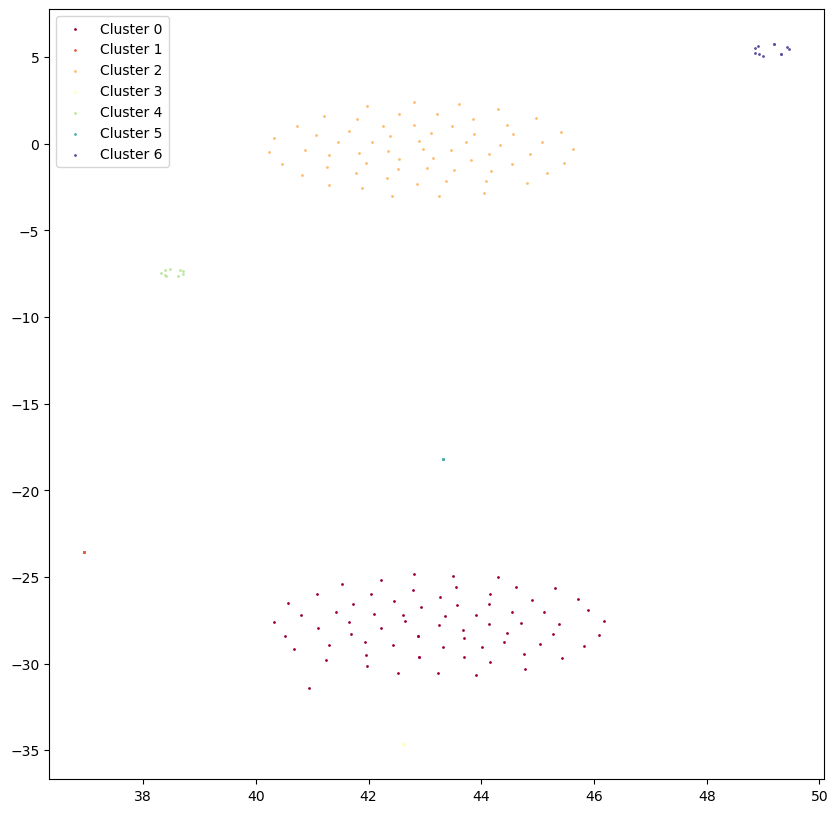

In [93]:
plot_labels(dbscan_labels[dbscan_no_outliers], X_tsne[dbscan_no_outliers])

In [92]:
get_symbols_for(results, dbscan_labels, 0)

array(['RUDB.U.TO', 'PYF.U.TO', 'DGS.TO', 'CMAR.TO', 'BNC.TO',
       'MPAY.U.TO', 'FEBB.F.TO', 'TDB.TO', 'MPAY.TO', 'PINC.TO', 'RQP.TO',
       'DF.PR.A.TO', 'FCSB.TO', 'XFLB.TO', 'CXF.TO', 'UCSH.U.TO',
       'SYLD.TO', 'XBB.TO', 'CGIN.U.TO', 'BOND.TO', 'BOND.B.TO', 'DXP.TO',
       'XSC.TO', 'FHIS.TO', 'CCOR.TO', 'CAFR.TO', 'EIT.PR.B.TO', 'NPS.TO',
       'PABF.TO', 'CINC.U.TO', 'EIT.UN.TO', 'PYF.B.TO', 'PBD.TO',
       'ZPAY.U.TO', 'SBC.TO', 'FSB.TO', 'YCM.TO', 'PVS.PR.J.TO',
       'ZCPB.TO', 'PTI.UN.TO', 'PMIF.TO', 'QUB.TO', 'CACB.TO', 'CMNY.TO',
       'ZST.TO', 'IWEB.TO', 'DXBU.TO', 'FLCP.TO', 'CDLB.B.TO',
       'EIT.PR.A.TO', 'DCC.TO', 'ZSU.TO', 'PIX.UN.TO', 'EBNK.U.TO',
       'CBH.TO', 'ZFM.TO', 'ICPB.TO', 'ZGRO.T.TO', 'ZEB.TO', 'ZSDB.TO',
       'PRP.TO', 'ZSB.TO', 'CINC.TO', 'ZQB.TO', 'ZAG.TO', 'ISIF.TO',
       'MKB.TO', 'DF.TO', 'TXT.PR.A.TO', 'PIN.TO', 'FPR.TO', 'BEPR.TO'],
      dtype='<U12')

In [37]:
get_symbols_for(results, labels, 2)

array(['YCM.PR.B.TO', 'HSUV.U.TO', 'PLDI.TO', 'XCB.TO', 'MNY.TO',
       'FCCB.TO', 'SPLT.TO', 'PFCB.TO', 'ZCS.L.TO', 'TCLB.TO', 'VGV.TO',
       'MFT.TO', 'RUSB.TO', 'FCRH.TO', 'MNU.U.TO', 'QASH.TO', 'PR.TO',
       'TUSB.TO', 'ZPS.TO', 'ZFS.TO', 'SPAY.TO', 'HTB.TO', 'BEPR.U.TO',
       'ZFL.TO', 'VGH.TO', 'FIG.U.TO', 'RLB.TO', 'FUD.TO', 'HPYT.U.TO',
       'CGIN.TO', 'PVS.PR.I.TO', 'LCS.PR.A.TO', 'PDF.TO', 'WFS.PR.A.TO',
       'FLCI.TO', 'PVS.PR.H.TO', 'UDEF.TO', 'RBN.UN.TO', 'FIG.TO',
       'ZUS.U.TO', 'QSB.TO', 'DCG.TO', 'LCS.TO', 'ZWC.TO', 'ZDB.TO',
       'XLB.TO', 'IGBT.UN.TO', 'HBND.TO', 'CCOR.U.TO', 'FGO.TO', 'LFE.TO',
       'YCM.PR.A.TO', 'VCNS.TO', 'HSAV.TO', 'PCON.TO', 'ZPAY.TO',
       'VSC.TO', 'VCB.TO', 'RPSB.TO', 'XMF.PR.B.TO', 'DCU.TO',
       'LFE.PR.B.TO', 'ENS.TO', 'ZPR.U.TO'], dtype='<U12')

- Observation
    - LFE.TO is Canadian Life Companies Split Corp
    - ZSC.L.TO is BMO Short Corporate Bond Index ETF.
    - Although both companies are within financial sector, they should not have ended up within the same cluster  

## Finishing remarks

   - We can use embedding to find clusters (sectors). However, since each financial product has different length of risks the embedding for them is different as well. As a result, we decided to sum those up to produce a single vector which we can use in our cluster exploration. This procedure of merging through sum might result in removing relationships between symbols. We can see this happening since the number of clusters produce is smaller than the number of companies that can be related together based on risks. For instance, although banks have similar risk profile to ETFs they should not be placed within the same risk bucket.
  - Validating clustering results in unsupervized setting is tricky. Doing it manually is time-consuming, maybe there's a better way to do this.

### Future work
- Instead of embedding risks separately, try embedding them together.
- Play around with prompt for generating risks and see if there's a way to create risks that are more similar.
- Use a model which is more domain specific to finance for embedding.
- Use embeddings from multiple models to see if it improves clustering.
- Think about a better way for validating clustering results.